In [1]:
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.anchored_artists import (AnchoredSizeBar)
import matplotlib.font_manager as fm
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import LogNorm
from astropy.visualization import ImageNormalize, LogStretch, AsinhStretch
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
import glob 
import os

%matplotlib inline

In [2]:
class Targets:

    def __init__(self,source_name,radio_freq,optical_filter,uv_filter):
        self.n = source_name
        self.fq = radio_freq
        self.fop = optical_filter
        self.fuv = uv_filter

In [3]:
s1 = Targets('0258+35', '22','f621m','f225w')
s2 = Targets('1014+392', '5', 'f845m', 'f336w')
s3 = Targets('1025+390', '5', 'f763m', 'f336w')
s4 = Targets('1037+30', '8', 'f621m', 'f225w')
s5 = Targets('1128+455', '15', 'f763m', 'f336w')
s6 = Targets('1201+394', '8', 'f845m', 'f336w')
s7 = Targets('1203+645', '5', 'f763m', 'f336w')
s8 = Targets('1221-423', '24', 'f689m', 'f275w')
s9 = Targets('1445+410', '5', 'f689m', 'f275w')      


In [4]:
hst_dir = '/Users/orion/phd_research/CSS2/hst_data/cropped_drc/'
radio_dir = '/Users/orion/phd_research/CSS2/radio/'

In [5]:
def read_radio(rdirname, s):
    
    #radio
    if (s.n == '1025+390') or (s.n == '1037+30') or (s.n == '1128+455'):
        rfile = get_pkg_data_filename(rdirname+s.n+'_'+s.fq+'GHz_cropped.fits')
        hdu_r = fits.open(rfile)
        d = hdu_r[0].data
        h = hdu_r[0].header
        
    elif (s.n == '1221-423'):
        rfile = get_pkg_data_filename(rdirname+s.n+'_'+s.fq+'GHz.fits')
        hdu_r = fits.open(rfile)
        d = hdu_r[0].data
        h = hdu_r[0].header
        
    else:
        rfile = get_pkg_data_filename(rdirname+s.n+'_'+s.fq+'GHz.fits')
        hdu = fits.open(rfile)
        d_init = hdu[0].data
        h = hdu[0].header
        hdu_r = d_init[0]
        d = hdu_r[0].data
        
    return d, h

        
def read_image(dirname, s, band):
        
    #optical
    if (band == 'op'):

        if (s.n == '1201+394') or (s.n == '1221-423'):
            opfile = get_pkg_data_filename(dirname+s.n+'_'+s.fop+'_new.fits')
            hdu_op = fits.open(opfile)[0]
        
        else:
            opfile = get_pkg_data_filename(dirname+s.n+'_'+s.fop+'_shifted.fits')
            hdu_op = fits.open(opfile)[0]
        
        return hdu_op
    
    #uv
    else:
        
        if (s.n == '1221-423'):
            uvfile = get_pkg_data_filename(dirname+s.n+'_'+s.fuv+'_new.fits')
            hdu_uv = fits.open(uvfile)[0]
            h = hdu_uv.header
            
        else:
            uvfile = get_pkg_data_filename(dirname+s.n+'_'+s.fuv+'_crayerased.fits')
            hdu_uv = fits.open(uvfile)[0]
            h = hdu_uv.header
        
        return hdu_uv, h


def find_optimal_wcs(dirname, s):
    
    if (s.n == '0258+35') or (s.n == '1014+392') or (s.n == '1201+394') or (s.n == '1221-423') or (s.n == '1445+410'):
        list_hdus = [fits.open(filenames)[0] for filenames in glob.glob(os.path.join(dirname, s.n+'_*_new.fits'))]
        wcs_out, shape_out = find_optimal_celestial_wcs(list_hdus)
        
    else:
        list_hdus = [fits.open(filenames)[0] for filenames in glob.glob(os.path.join(dirname, s.n+'_*_shifted.fits'))]
        wcs_out, shape_out = find_optimal_celestial_wcs(list_hdus)

    return wcs_out, shape_out
    


In [6]:
def radio_contours(rms_sigma):
    
    lp= []
    for i in range(0,10):
        lp.append(2**i*rms_sigma)

    ln= []
    for i in range(0,2):
        ln.append(-2**i*rms_sigma)
        ln.sort()
    
    return lp,ln  


In [7]:
def plot_opradio(s, wcs, hdulistOP_data, hdulistR_data, hdulistR_header):
    
    plt.rcParams['axes.linewidth'] = 0.7
    plt.rcParams['axes.edgecolor'] = 'k'
    plt.rcParams['font.family'] = 'sans-serif'
    fig = plt.figure(figsize=(14,18))
    plt.subplots_adjust(wspace=0.35, hspace=0.2)

    ax1 = fig.add_subplot(331, projection=optimal_wcs[0])   
    ax2 = fig.add_subplot(332, projection=optimal_wcs[1])    
    ax3 = fig.add_subplot(333, projection=optimal_wcs[2])
    ax4 = fig.add_subplot(334, projection=optimal_wcs[3])    
    ax5 = fig.add_subplot(335, projection=optimal_wcs[4])
    ax6 = fig.add_subplot(336, projection=optimal_wcs[5])
    ax7 = fig.add_subplot(337, projection=optimal_wcs[6])
    ax8 = fig.add_subplot(338, projection=optimal_wcs[7])
    ax9 = fig.add_subplot(339, projection=optimal_wcs[8])
    
    for ax in fig.get_axes():
        ax.tick_params(axis='both', color='k',direction='in',which='major',length=4, 
                       width=0.5, labelsize=10, pad=5.0)
        ax.tick_params(which='minor',length=2)
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel(r'$ \alpha $', size=13)
        lat.set_axislabel('$ \delta $', minpad=-1.0, size=13)
        lon.set_ticks(number=6)
        lat.set_ticks(number=5)
        #lon.set_ticks(spacing=10 * u.arcmin, color='k')
        #lat.set_ticks(spacing=10 * u.arcmin, color='k')
        lat.display_minor_ticks(True)
        lon.display_minor_ticks(True)
        lon.set_minor_frequency(4)
        lat.set_minor_frequency(4)
        lon.set_ticklabel(exclude_overlapping=True)
        lat.set_ticklabel(exclude_overlapping=True)
        #lon.set_separator(('d', "'", '"'))
        lon.set_major_formatter('hh:mm:ss.s')      

 

    cmap='BuPu'
    
    #source 3: 1025
    rms=0.5e-3
    lp,ln = radio_contours(3*rms)
    norm1 = ImageNormalize(stretch=AsinhStretch(), vmin=0.008, vmax=0.15) 
    ax3.imshow(hdulistOP_data[2], origin='lower', cmap= cmap, interpolation='none', norm=norm1, aspect="auto")
    l = [0.008,0.014,0.021,0.028,0.039,0.068,0.089,0.12,0.15,0.2]
    ax3.contour(hdulistR_data[2], transform=ax3.get_transform(WCS(hdulistR_header[2], naxis=2)),levels=lp, 
                  colors='k', linewidths=0.5)   
    ax3.set_xlim(250, 390)
    ax3.set_ylim(255, 445)
    Afont1 = {'color': 'k','weight': 'normal','size': 20}
    at1 = AnchoredText('1025+390',loc='upper left', pad=0.5, borderpad=0.3, prop=Afont1, frameon=False)
    ax3.add_artist(at1)
    
    
    #source 4: 1037
    rms = 1.602e-04
    lp,ln = radio_contours(3*rms)
    norm4 = ImageNormalize(stretch=AsinhStretch(), vmin=0.0, vmax=2.0) 
    ax4.imshow(hdulistOP_data[3], origin='lower', cmap= cmap, interpolation='none', norm=norm4, aspect="auto") 
    ax4.contour(hdulistR_data[3], transform=ax4.get_transform(WCS(hdulistR_header[3], naxis=2)),
           levels=lp, colors='k', linewidths=0.3)
    ax4.set_xlim(90, 310)
    ax4.set_ylim(70, 330)
    Afont1 = {'color': 'k','weight': 'normal','size': 20}
    at1 = AnchoredText('1037+30',loc='upper left', pad=0.5, borderpad=0.3, prop=Afont1, frameon=False)
    ax4.add_artist(at1)

    
    #source 5: 1128
    rms = 6.947e-04
    lp,ln = radio_contours(3*rms)
    norm2 = ImageNormalize(stretch=AsinhStretch(), vmin=0.01, vmax=0.25) 
    ax5.imshow(hdulistOP_data[4], origin='lower', cmap= cmap, interpolation='none', norm=norm2, aspect="auto") 
    l = [0.04,0.06,0.10,0.17,0.26,0.38,0.53,0.71]
    ax5.contour(hdulistR_data[4], transform=ax5.get_transform(WCS(hdulistR_header[4], naxis=2)),levels=lp, 
           colors='k', linewidths=0.5)
    ax5.set_xlim(210, 290)
    ax5.set_ylim(180, 290)
    Afont1 = {'color': 'k','weight': 'normal','size': 20}
    at1 = AnchoredText('1128+455',loc='upper left', pad=0.5, borderpad=0.3, prop=Afont1, frameon=False)
    ax5.add_artist(at1)

    
    #source 6: 1201
    rms = 4.74e-04
    lp,ln = radio_contours(rms)
    norm3 = ImageNormalize(stretch=AsinhStretch(), vmin=0.02, vmax=0.1) 
    ax6.imshow(hdulistOP_data[5], origin='lower', cmap= cmap, interpolation='none', norm=norm3, aspect="auto") 
    ax6.contour(hdulistR_data[5], transform=ax6.get_transform(WCS(hdulistR_header[5], naxis=2)),
           levels=lp, colors='k', linewidths=0.5)
    ax6.set_xlim(180, 280)
    ax6.set_ylim(170, 280)
    Afont1 = {'color': 'k','weight': 'normal','size': 20}
    at1 = AnchoredText('1201+394',loc='upper left', pad=0.5, borderpad=0.3, prop=Afont1, frameon=False)
    ax6.add_artist(at1)
    
    
    #source 7: 1203
    rms = 0.3e-3
    lp,ln = radio_contours(3*rms)
    norm5 = ImageNormalize(stretch=AsinhStretch(), vmin=0.011, vmax=0.05) 
    ax7.imshow(hdulistOP_data[6], origin='lower', cmap= cmap, interpolation='none', norm=norm5, aspect="auto") 
    ax7.contour(hdulistR_data[6], transform=ax7.get_transform(WCS(hdulistR_header[6], naxis=2)),
            levels=lp, colors='k', linewidths=0.5)
    ax7.set_xlim(240, 360)
    ax7.set_ylim(240, 360)
    Afont1 = {'color': 'k','weight': 'normal','size': 20}
    at1 = AnchoredText('1203+645',loc='upper left', pad=0.5, borderpad=0.3, prop=Afont1, frameon=False)
    ax7.add_artist(at1)
    
    
    #source 8: 1221
    rms = 3.156e-04
    lp,ln = radio_contours(3*rms)
    norm6 = ImageNormalize(stretch=AsinhStretch(), vmin=0.05, vmax=0.5) 
    ax8.imshow(hdulistOP_data[7], origin='lower', cmap= cmap, interpolation='none', norm=norm6, aspect="auto") 
    ax8.contour(hdulistR_data[7], transform=ax8.get_transform(WCS(hdulistR_header[7], naxis=2)),
           levels=lp, colors='k', linewidths=0.5)
    ax8.set_xlim(220, 510)
    ax8.set_ylim(190, 520)
    Afont1 = {'color': 'k','weight': 'normal','size': 20}
    at1 = AnchoredText('1221-423',loc='upper left', pad=0.5, borderpad=0.3, prop=Afont1, frameon=False)
    ax8.add_artist(at1)
    
    
    #source 1: 0258
    rms=7.28e-05
    lp,ln = radio_contours(3*rms)
    norm7 = ImageNormalize(stretch=AsinhStretch(), vmin=1.5, vmax=14.0) 
    ax1.imshow(hdulistOP_data[0], origin='lower', cmap= cmap, interpolation='none', norm=norm7, aspect="auto")
    ax1.contour(hdulistR_data[0], transform=ax1.get_transform(WCS(hdulistR_header[0], naxis=2)),levels=lp, 
            colors='k', linewidths=0.5)
    ax1.set_xlim(520, 590)
    ax1.set_ylim(590, 660)
    Afont1 = {'color': 'k','weight': 'normal','size': 20}
    at1 = AnchoredText('0258+35',loc='upper left', pad=0.5, borderpad=0.3, prop=Afont1, frameon=False)
    ax1.add_artist(at1)

    
    #source 2: 1014
    rms=1.39e-04
    lp,ln = radio_contours(3*rms)
    norm8 = ImageNormalize(stretch=AsinhStretch(), vmin=0.01, vmax=0.05) 
    ax2.imshow(hdulistOP_data[1], origin='lower', cmap= cmap, interpolation='none', norm=norm8, aspect="auto")
    ax2.contour(hdulistR_data[1], transform=ax2.get_transform(WCS(hdulistR_header[1], naxis=2)),levels=lp, 
                colors='k', linewidths=0.4)
    ax2.set_xlim(300, 400)
    ax2.set_ylim(410, 580)
    Afont1 = {'color': 'k','weight': 'normal','size': 20}
    at1 = AnchoredText('1014+392',loc='upper left', pad=0.5, borderpad=0.3, prop=Afont1, frameon=False)
    ax2.add_artist(at1)

    #source 9: 1445
    rms=2.55e-04
    lp,ln = radio_contours(3*rms)
    norm9 = ImageNormalize(stretch=AsinhStretch(), vmin=0.01, vmax=0.5) 
    ax9.imshow(hdulistOP_data[8], origin='lower', cmap= cmap, interpolation='none', norm=norm9, aspect="auto")
    ax9.contour(hdulistR_data[8], transform=ax9.get_transform(WCS(hdulistR_header[8], naxis=2)),levels=lp, 
            colors='k', linewidths=0.5)
    ax9.set_xlim(120, 220)
    ax9.set_ylim(100, 250)
    Afont1 = {'color': 'k','weight': 'normal','size': 20}
    at1 = AnchoredText('1445+410',loc='upper left', pad=0.5, borderpad=0.3, prop=Afont1, frameon=False)
    ax9.add_artist(at1)


0258+35
(512, 512)
1014+392
(1041, 1031)


 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


1025+390
(101, 126)


1037+30
(450, 680)
1128+455
(141, 171)


1201+394
(1024, 1024)
1203+645
(1024, 1024)
1221-423
(59, 47)


1445+410
(1041, 1031)


 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


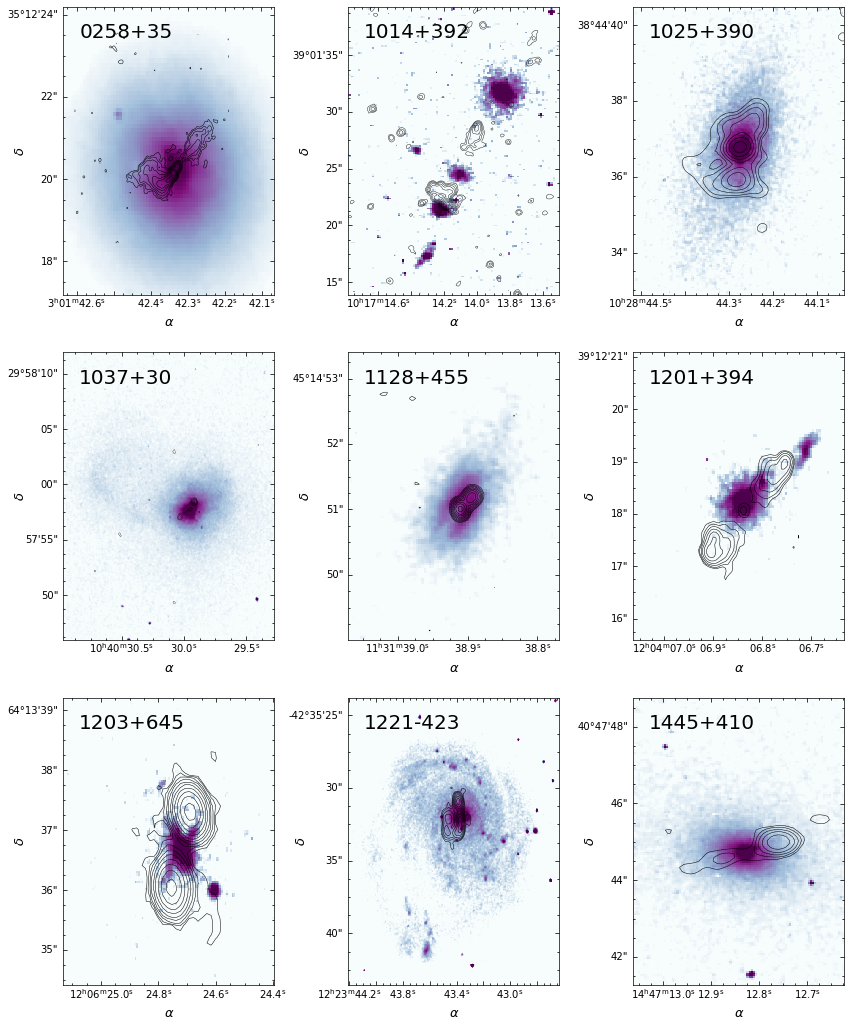

In [8]:
hdu_listOP = []
hdu_listR = []
hdu_listR_header = []
optimal_wcs = []

sources = [s1, s2, s3, s4, s5, s6, s7, s8, s9]

for s in sources:

    print(s.n)
    image_hdu = read_image(hst_dir, s, 'op')
    rdata, header = read_radio(radio_dir, s)
    print(rdata.shape)
    
    new_wcs, new_shape = find_optimal_wcs(hst_dir, s)
    reprojected_op, reprojected_op_footprint = reproject_interp(image_hdu, new_wcs, new_shape)
    reprojected_op = gaussian_filter(reprojected_op, 0.5)
    
    optimal_wcs.append(new_wcs)
    hdu_listOP.append(reprojected_op)
    hdu_listR.append(rdata)
    hdu_listR_header.append(header)


plot_opradio(s, optimal_wcs, hdu_listOP, hdu_listR, hdu_listR_header)

#plt.savefig('op-radio.pdf',facecolor='w', dpi=1000, bbox_inches='tight', pad_inches=0.5)


In [11]:
image_hdu.data.dtype

dtype('>f4')

In [9]:
def plot_uvradio(s, optimal_wcs, photflam, hdulistUV_data, hdulistR_data, hdulistR_header):

    plt.rcParams['axes.linewidth'] = 0.9
    plt.rcParams['axes.edgecolor'] = 'k'
    plt.rcParams['font.family'] = 'sans-serif' 

    fig = plt.figure(figsize=(18,22)) 
    plt.subplots_adjust(wspace=0.20, hspace=0.20)

    ax1 = fig.add_subplot(331, projection=optimal_wcs[0])
    ax2 = fig.add_subplot(332, projection=optimal_wcs[1])    
    ax3 = fig.add_subplot(333, projection=optimal_wcs[2])
    ax4 = fig.add_subplot(334, projection=optimal_wcs[3])    
    ax5 = fig.add_subplot(335, projection=optimal_wcs[4])  
    ax6 = fig.add_subplot(336, projection=optimal_wcs[5])

    for ax in fig.get_axes():
    
        ax.tick_params(axis='both', color='k',direction='in',which='major')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
    
            
    cmap='magma'


    #   1025
    factor1 = photflam[0]/1e-20
    im1 = ax1.imshow(hdulistUV_data[0]*factor1, origin='lower', vmin=0.001*factor1, vmax=0.017*factor1, 
                 cmap= cmap, interpolation='none', aspect="auto")

    rms=0.5e-3
    lp,ln = radio_contours(3*rms)
   
    ax1.contour(hdulistR_data[0], transform=ax1.get_transform(WCS(hdulistR_header[0], naxis=2)),levels=lp, 
                  colors='white', linewidths=0.8)
    ax1.contour(hdulistR_data[0], transform=ax1.get_transform(WCS(hdulistR_header[0], naxis=2)),levels=ln, 
                  colors='white', linewidths=0.8,linestyle='--')
    ax1.set_xlim(270, 370)
    ax1.set_ylim(295, 425)
    fontprops = fm.FontProperties(size=16)
    bar = AnchoredSizeBar(transform=ax1.transData, size=30, size_vertical=0.5,
                      loc='lower right', pad=0.1, borderpad=2.0, sep= -20,
                      color='white', label='7 kpc', frameon=False, fontproperties=fontprops)
    ax1.add_artist(bar)

    Afont1 = {'family': 'sans-serif', 'color': 'white','weight': 'normal','size': 18}
    at1 = AnchoredText('1025+390',loc='upper left', pad=0.5, borderpad=0.5, prop=Afont1, frameon=False)
    ax1.add_artist(at1)

    Afont2 = {'family': 'sans-serif','color':  'white','weight': 'normal','size': 13}
    at2 = AnchoredText('5 GHz Contours',loc='upper left', pad=2.0, borderpad=1.0, prop=Afont2, frameon=False)
    ax1.add_artist(at2)
    
    cbar1 = fig.colorbar(im1, ax=ax1, pad = 0.01, aspect=12, format= "%.1f")
    cbar1.ax.tick_params(direction='in') 
    cbar1.outline.set_visible(False)

    
    #   1037
    factor2 = photflam[1]/1e-20 
    im2 = ax2.imshow(hdulistUV_data[1]*factor2, origin='lower', vmin=0.002*factor2, vmax=0.14*factor2, 
           cmap= cmap, interpolation='none', aspect="auto") 

    rms = 1.602e-04
    lp,ln = radio_contours(3*rms)

    ax2.contour(hdulistR_data[1], transform=ax2.get_transform(WCS(hdulistR_header[1], naxis=2)),levels=lp, 
           colors='k', linewidths=0.8)
    ax2.contour(hdulistR_data[1], transform=ax2.get_transform(WCS(hdulistR_header[1], naxis=2)),levels=ln, 
           colors='k', linewidths=0.8, linestyle='--')
    ax2.set_xlim(170, 280)
    ax2.set_ylim(100, 290)

    fontprops = fm.FontProperties(size=16)
    bar2 = AnchoredSizeBar(transform=ax2.transData, size=28, size_vertical=0.5,
                      loc='lower right', pad=0.1, borderpad=2.0, sep= -20,
                      color='white', label='5 kpc', frameon=False, fontproperties=fontprops)
    ax2.add_artist(bar2)

    Afont1 = {'family': 'sans-serif', 'color': 'white','weight': 'normal','size': 18}
    at1 = AnchoredText('1037+30',loc='upper left', pad=0.5, borderpad=0.5, prop=Afont1, frameon=False)
    ax2.add_artist(at1)
    
    Afont2 = {'family': 'sans-serif','color':  'white','weight': 'normal','size': 13}
    at2 = AnchoredText('8 GHz Contours',loc='upper left', pad=2.0, borderpad=1.0, prop=Afont2, frameon=False)
    ax2.add_artist(at2)

    cbar2 = fig.colorbar(im2, ax=ax2, pad = 0.01, aspect=12, format= "%.1f") 
    cbar2.ax.tick_params(direction='in') 
    cbar2.outline.set_visible(False)


    #   1128
    factor3 = photflam[2]/1e-20
    im3 = ax3.imshow(hdulistUV_data[2]*factor3, origin='lower', vmin=0.002*factor3, vmax=0.010*factor3, 
           cmap= cmap, interpolation='none', aspect="auto") 

    rms = 6.947e-04
    lp,ln = radio_contours(3*rms)
    
    ax3.contour(hdulistR_data[2], transform=ax3.get_transform(WCS(hdulistR_header[2], naxis=2)),
           levels=lp, colors='k', linewidths=0.8)
    ax3.contour(hdulistR_data[2], transform=ax3.get_transform(WCS(hdulistR_header[2], naxis=2)),
           levels=ln, colors='white', linewidths=0.8, linestyle='--')
    ax3.set_xlim(215, 285)
    ax3.set_ylim(190, 280)

    fontprops = fm.FontProperties(size=16)
    bar3 = AnchoredSizeBar(transform=ax3.transData, size=25, size_vertical=0.3,
                      loc='lower right', pad=0.1, borderpad=2.0, sep= -20,
                      color='white', label='8 kpc', frameon=False, fontproperties=fontprops)
    ax3.add_artist(bar3)

    Afont1 = {'family': 'sans-serif', 'color': 'white','weight': 'normal','size': 18}
    at1 = AnchoredText('1128+455',loc='upper left', pad=0.5, borderpad=0.5, prop=Afont1, frameon=False)
    ax3.add_artist(at1)

    Afont2 = {'family': 'sans-serif','color':  'white','weight': 'normal','size': 13}
    at2 = AnchoredText('15 GHz Contours',loc='upper left', pad=2.0, borderpad=1.0, prop=Afont2, frameon=False)
    ax3.add_artist(at2)

    cbar3 = fig.colorbar(im3, ax=ax3, pad = 0.01, aspect=12, format= "%.1f") 
    cbar3.ax.tick_params(direction='in') 
    cbar3.outline.set_visible(False)


    #   1201
    factor4 = photflam[3]/1e-20
    im4 = ax4.imshow(hdulistUV_data[3]*factor4, origin='lower', vmin=0.0025*factor4, vmax=0.008*factor4, 
           cmap= cmap, interpolation='none', aspect="auto") 

    rms = 4.74e-04
    lp,ln = radio_contours(rms)
    
    ax4.contour(hdulistR_data[3], transform=ax4.get_transform(WCS(hdulistR_header[3], naxis=2)),
           levels=lp, colors='white', linewidths=0.8)
    ax4.contour(hdulistR_data[3], transform=ax4.get_transform(WCS(hdulistR_header[3], naxis=2)),
           levels=ln, colors='white', linewidths=0.8, linestyle='--')
    ax4.set_xlim(180, 280)
    ax4.set_ylim(170, 275)

    fontprops = fm.FontProperties(size=16)
    bar4 = AnchoredSizeBar(transform=ax4.transData, size=25, size_vertical=0.5,
                      loc='lower right', pad=0.1, borderpad=2.0, sep= -20,
                      color='white', label='9 kpc', frameon=False, fontproperties=fontprops)
    ax4.add_artist(bar4)

    Afont1 = {'family': 'sans-serif', 'color': 'white','weight': 'normal','size': 18}
    at1 = AnchoredText('1201+394',loc='upper left', pad=0.5, borderpad=0.5, prop=Afont1, frameon=False)
    ax4.add_artist(at1)

    Afont2 = {'family': 'sans-serif','color':  'white','weight': 'normal','size': 13}
    at2 = AnchoredText('8 GHz Contours',loc='upper left', pad=2.0, borderpad=1.0, prop=Afont2, frameon=False)
    ax4.add_artist(at2)

    cbar4 = fig.colorbar(im4, ax=ax4, pad = 0.01, aspect=12, format= "%.1f") 
    cbar4.ax.tick_params(direction='in') 
    cbar4.outline.set_visible(False)


    #   1203
    factor5 = photflam[4]/1e-20
    im5 = ax5.imshow(hdulistUV_data[4]*factor5, origin='lower', vmin=0.002*factor5, vmax=0.010*factor5, 
           cmap= cmap, interpolation='none', aspect="auto") 

    rms = 0.3e-3
    lp,ln = radio_contours(3*rms)

    ax5.contour(hdulistR_data[4], transform=ax5.get_transform(WCS(hdulistR_header[4], naxis=2)),
           levels=lp, colors ='white', linewidths=0.8)
    ax5.contour(hdulistR_data[4], transform=ax5.get_transform(WCS(hdulistR_header[4], naxis=2)),
           levels=ln, colors ='white', linewidths=0.8,linestyle='--')
    ax5.set_xlim(210, 380)
    ax5.set_ylim(210, 380)

    fontprops = fm.FontProperties(size=16)
    bar5 = AnchoredSizeBar(transform=ax5.transData, size=32, size_vertical=0.5,
                      loc='lower right', pad=0.1, borderpad=2.0, sep= -20,
                      color='white', label='15 kpc', frameon=False, fontproperties=fontprops)
    ax5.add_artist(bar5)

    Afont1 = {'family': 'sans-serif', 'color': 'white','weight': 'normal','size': 18}
    at1 = AnchoredText('1203+645',loc='upper left', pad=0.5, borderpad=0.5, prop=Afont1, frameon=False)
    ax5.add_artist(at1)

    Afont2 = {'family': 'sans-serif','color':  'white','weight': 'normal','size': 13}
    at2 = AnchoredText('5 GHz Contours',loc='upper left', pad=2.0, borderpad=1.0, prop=Afont2, frameon=False)
    ax5.add_artist(at2)

    cbar5 = fig.colorbar(im5, ax=ax5, pad = 0.01, aspect=12, format= "%.1f") 
    cbar5.ax.tick_params(direction='in') 
    cbar5.outline.set_visible(False)


    #   1221
    factor6 = photflam[5]/1e-20
    im6 = ax6.imshow(hdulistUV_data[5]*factor6, origin='lower', vmin=0.002*factor6, vmax=0.02*factor6, 
           cmap= cmap, interpolation='none', aspect="auto") 

    rms = 3.156e-04
    lp,ln = radio_contours(3*rms)
    
    ax6.contour(hdulistR_data[5], transform=ax6.get_transform(WCS(hdulistR_header[5], naxis=2)),
           levels=lp, colors='white', linewidths=0.8)
    ax6.contour(hdulistR_data[5], transform=ax6.get_transform(WCS(hdulistR_header[5], naxis=2)),
           levels=ln, colors='white', linewidths=0.8)
    ax6.set_xlim(310, 410)
    ax6.set_ylim(315, 445)

    fontprops = fm.FontProperties(size=16)
    bar6 = AnchoredSizeBar(transform=ax6.transData, size=40, size_vertical=0.4,
                      loc='lower right', pad=0.1, borderpad=2.0, sep= -20,
                      color='white', label='7 kpc', frameon=False, fontproperties=fontprops)
    ax6.add_artist(bar6)

    Afont1 = {'family': 'sans-serif', 'color': 'white','weight': 'normal','size': 18}
    at1 = AnchoredText('1221-423',loc='upper left', pad=0.5, borderpad=0.5, prop=Afont1, frameon=False)
    ax6.add_artist(at1)

    Afont2 = {'family': 'sans-serif','color':  'white','weight': 'normal','size': 13}
    at2 = AnchoredText('24 GHz Contours',loc='upper left', pad=2.0, borderpad=1.0, prop=Afont2, frameon=False)
    ax6.add_artist(at2)

    cbar6 = fig.colorbar(im6, ax=ax6, pad = 0.01, aspect=12, format= "%.1f") 
    cbar6.ax.tick_params(direction='in') 
    cbar6.outline.set_visible(False)
    


1025+390
(101, 126)


(687, 625)
1037+30
(450, 680)
(401, 408)
1128+455
(141, 171)


(464, 494)
1201+394
(1024, 1024)
(437, 449)
1203+645
(1024, 1024)
(547, 547)
1221-423
(59, 47)


(697, 727)


/Users/orion/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


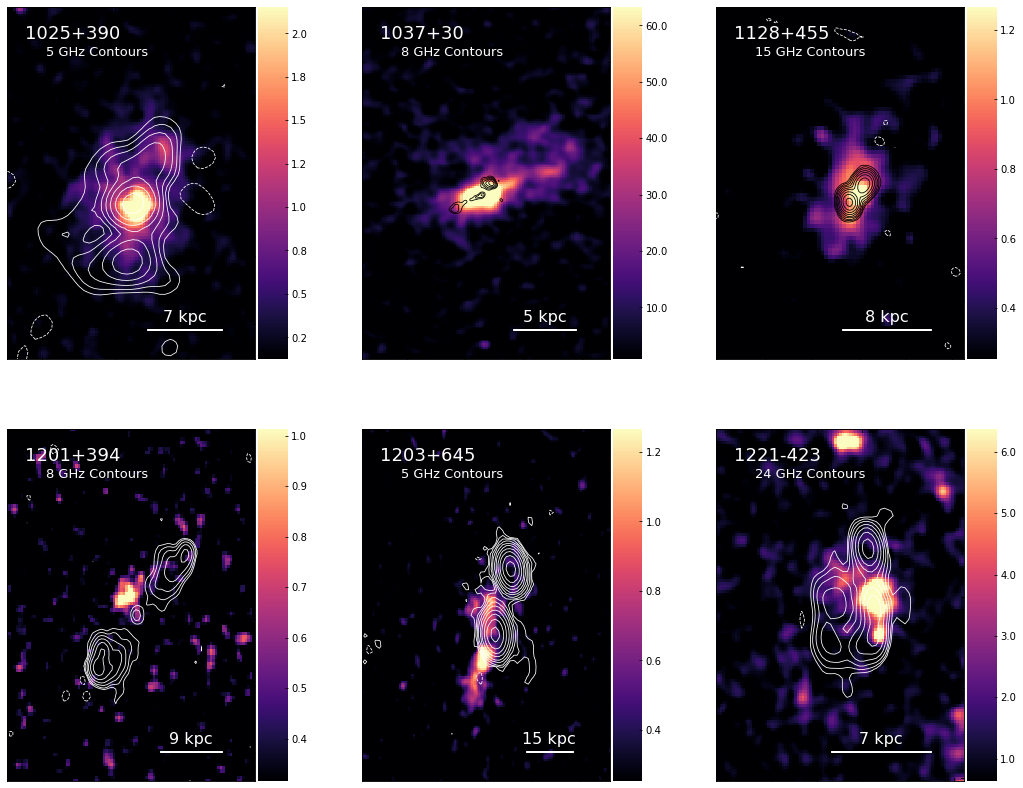

In [10]:
hdu_listUV = []
hdu_listR = []
hdu_listR_header = []
optimal_wcs = []
photflam = []

sources = [s3, s4, s5, s6, s7, s8]

for s in sources:

    print(s.n)
    image_hdu, header_hdu = read_image(hst_dir, s, 'uv')
    photflam.append(header_hdu['PHOTFLAM'])
    
    rdata, header = read_radio(radio_dir, s)
    print(rdata.shape)
    
    new_wcs, new_shape = find_optimal_wcs(hst_dir, s)
    reprojected_uv, reprojected_uv_footprint = reproject_interp(image_hdu, new_wcs, new_shape)
    reprojected_uv = gaussian_filter(reprojected_uv, 1.0) if s.n == '1201+394' else gaussian_filter(reprojected_uv, 1.5)
    
    print(reprojected_uv.shape)
    
    optimal_wcs.append(new_wcs)
    hdu_listUV.append(reprojected_uv)
    hdu_listR.append(rdata)
    hdu_listR_header.append(header)


plot_uvradio(s, optimal_wcs, photflam, hdu_listUV, hdu_listR, hdu_listR_header)

#plt.savefig('uv-radio.pdf',facecolor='w', dpi=1000, bbox_inches='tight', pad_inches=0.5)


In [11]:
def plot_uvop(s, optimal_wcs, photflam, hdulistUV_data, hdulistOP_data):

    plt.rcParams['axes.linewidth'] = 0.9
    plt.rcParams['axes.edgecolor'] = 'k'
    plt.rcParams['font.family'] = 'sans-serif' 

    fig = plt.figure(figsize=(18,22)) 
    plt.subplots_adjust(wspace=0.20, hspace=0.20)

    ax1 = fig.add_subplot(331, projection=optimal_wcs[0])
    ax2 = fig.add_subplot(332, projection=optimal_wcs[1])    
    ax3 = fig.add_subplot(333, projection=optimal_wcs[2])
    ax4 = fig.add_subplot(334, projection=optimal_wcs[3])    
    ax5 = fig.add_subplot(335, projection=optimal_wcs[4])  
    ax6 = fig.add_subplot(336, projection=optimal_wcs[5])

    for ax in fig.get_axes():
    
        ax.tick_params(axis='both',color='white',direction='in')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
        lat.display_minor_ticks(False)
        lon.display_minor_ticks(False)
            
    cmap='gist_heat_r'
   
    hdulistUV_data[1][hdulistUV_data[1] < 0.006] = np.nan
    hdulistUV_data[2][hdulistUV_data[2] < 0.003] = np.nan
    hdulistUV_data[3][hdulistUV_data[3] < 0.0035] = np.nan
    hdulistUV_data[4][hdulistUV_data[4] < 0.003] = np.nan
    hdulistUV_data[5][hdulistUV_data[5] < 0.005] = np.nan
    
    
    #   1025
    factor1 = photflam[0]/1e-20
    im1 = ax1.imshow(hdulistUV_data[0]*factor1, vmin=0.004*factor1, vmax=0.018*factor1, 
                     origin='lower', cmap=cmap, interpolation='none') 

    ax1.contour(hdulistOP_data[0], transform=ax1.get_transform(optimal_wcs[0]),
               levels=[0.02,0.035,0.05,0.06,0.11,0.14,0.17,0.2],colors='midnightblue', alpha=1.0, linewidths=0.7)
    ax1.set_xlim(270, 370)
    ax1.set_ylim(290, 430)
    
    bar = AnchoredSizeBar(transform=ax1.transData, size=30, size_vertical=0.5,
                      loc='lower right', pad=0.1, borderpad=2.0, sep= -20,
                      color='k', label='7 kpc', frameon=False, fontproperties=fm.FontProperties(size=16))
    ax1.add_artist(bar)

    Afont1 = {'family': 'sans-serif', 'color': 'k','weight': 'normal','size': 22}
    at1 = AnchoredText('1025+390',loc='upper left', pad=0.5, borderpad=0.5, prop=Afont1, frameon=False)
    ax1.add_artist(at1)

    cbar1 = fig.colorbar(im1, ax=ax1, pad = 0.01, aspect=12, format= "%.1f")
    cbar1.ax.tick_params(direction='in') 
    cbar1.outline.set_visible(False)

    
    #   1037
    factor2 = photflam[1]/1e-20
    im2 = ax2.imshow(hdulistUV_data[1]*factor2, origin='lower', vmin=0.01*factor2, vmax=0.15*factor2, 
           cmap=cmap, interpolation='none', aspect="auto") 

    ax2.contour(hdulistOP_data[1], transform=ax2.get_transform(optimal_wcs[1]),
                levels=[0.06,0.22,0.37,0.53,0.66,0.84,1.0], colors='midnightblue', alpha=1.0, linewidths=0.7)
    ax2.set_xlim(100, 310)
    ax2.set_ylim(80, 310)

    bar2 = AnchoredSizeBar(transform=ax2.transData, size=28, size_vertical=0.5,
                      loc='lower right', pad=0.1, borderpad=2.0, sep= -20,
                      color='k', label='5 kpc', frameon=False, fontproperties=fm.FontProperties(size=16))
    ax2.add_artist(bar2)

    Afont1 = {'family': 'sans-serif', 'color': 'k','weight': 'normal','size': 22}
    at1 = AnchoredText('1037+30',loc='upper left', pad=0.5, borderpad=0.5, prop=Afont1, frameon=False)
    ax2.add_artist(at1)
    
    cbar2 = fig.colorbar(im2, ax=ax2, pad = 0.01, aspect=12, format= "%.1f") 
    cbar2.ax.tick_params(direction='in') 
    cbar2.outline.set_visible(False)


    #   1128
    factor3 = photflam[2]/1e-20
    im3 = ax3.imshow(hdulistUV_data[2]*factor3, origin='lower', vmin=0.002*factor3, vmax=0.011*factor3, 
           cmap= cmap, interpolation='none', aspect="auto") 

    ax3.contour(hdulistOP_data[2], transform=ax3.get_transform(optimal_wcs[2]),
                levels=[0.01,0.03,0.05,0.075,0.09,0.11], colors='midnightblue', alpha=1.0, linewidths=0.7)
    ax3.set_xlim(200, 330)
    ax3.set_ylim(150, 320)

    bar3 = AnchoredSizeBar(transform=ax3.transData, size=25, size_vertical=0.5,
                      loc='lower right', pad=0.1, borderpad=2.0, sep= -20,
                      color='k', label='8 kpc', frameon=False, fontproperties=fm.FontProperties(size=16))
    ax3.add_artist(bar3)

    Afont1 = {'family': 'sans-serif', 'color': 'k','weight': 'normal','size': 22}
    at1 = AnchoredText('1128+455',loc='upper left', pad=0.5, borderpad=0.5, prop=Afont1, frameon=False)
    ax3.add_artist(at1)

    cbar3 = fig.colorbar(im3, ax=ax3, pad = 0.01, aspect=12, format= "%.1f") 
    cbar3.ax.tick_params(direction='in') 
    cbar3.outline.set_visible(False)


    #   1201
    factor4 = photflam[3]/1e-20
    im4 = ax4.imshow(hdulistUV_data[3]*factor4, origin='lower', vmin=0.002*factor4, vmax=0.011*factor4, 
           cmap= cmap, interpolation='none', aspect="auto") 

    ax4.contour(hdulistOP_data[3], transform=ax4.get_transform(optimal_wcs[3]),levels=[0.02,0.03,0.07,0.11,0.16,0.2], 
           colors='midnightblue', alpha=1.0, linewidths=0.7)
    ax4.set_xlim(180, 290)
    ax4.set_ylim(165, 295)

    fontprops = fm.FontProperties(size=16)
    bar4 = AnchoredSizeBar(transform=ax4.transData, size=25, size_vertical=0.5,
                      loc='lower right', pad=0.1, borderpad=2.0, sep= -20,
                      color='k', label='9 kpc', frameon=False, fontproperties=fm.FontProperties(size=16))
    ax4.add_artist(bar4)

    Afont1 = {'family': 'sans-serif', 'color': 'k','weight': 'normal','size': 22}
    at1 = AnchoredText('1201+394',loc='upper left', pad=0.5, borderpad=0.5, prop=Afont1, frameon=False)
    ax4.add_artist(at1)

    cbar4 = fig.colorbar(im4, ax=ax4, pad = 0.01, aspect=12, format= "%.1f") 
    cbar4.ax.tick_params(direction='in') 
    cbar4.outline.set_visible(False)


    #   1203
    factor5 = photflam[4]/1e-20
    im5 = ax5.imshow(hdulistUV_data[4]*factor5, origin='lower', vmin=0.002*factor5, vmax=0.013*factor5, 
           cmap=cmap, interpolation='none', aspect="auto") 
    
    ax5.contour(hdulistOP_data[4], transform=ax5.get_transform(optimal_wcs[4]),
            levels=[0.009,0.015,0.025,0.04,0.055,0.07,0.085,1.0], colors='midnightblue', alpha=1.0, linewidths=0.7)
    ax5.set_xlim(230, 380)
    ax5.set_ylim(200, 380)

    fontprops = fm.FontProperties(size=16)
    bar5 = AnchoredSizeBar(transform=ax5.transData, size=32, size_vertical=0.5,
                      loc='lower right', pad=0.1, borderpad=2.0, sep= -20,
                      color='k', label='15 kpc', frameon=False, fontproperties=fm.FontProperties(size=16))
    ax5.add_artist(bar5)

    Afont1 = {'family': 'sans-serif', 'color': 'k','weight': 'normal','size': 22}
    at1 = AnchoredText('1203+645',loc='upper left', pad=0.5, borderpad=0.5, prop=Afont1, frameon=False)
    ax5.add_artist(at1)

    cbar5 = fig.colorbar(im5, ax=ax5, pad = 0.01, aspect=12, format= "%.1f") 
    cbar5.ax.tick_params(direction='in') 
    cbar5.outline.set_visible(False)


    #   1221
    factor6 = photflam[5]/1e-20
    im6 = ax6.imshow(hdulistUV_data[5]*factor6, origin='lower', vmin=0.003*factor6, vmax=0.03*factor6, 
           cmap=cmap, interpolation='none', aspect="auto") 
    
    ax6.contour(hdulistOP_data[5], transform=ax6.get_transform(optimal_wcs[5]),
                levels=[0.04,0.08,0.12,0.17,0.21,0.26,0.3], colors='midnightblue', alpha=1.0, linewidths=0.7)
    ax6.set_xlim(180, 570)
    ax6.set_ylim(120, 630)

    fontprops = fm.FontProperties(size=16)
    bar6 = AnchoredSizeBar(transform=ax6.transData, size=90, size_vertical=1.8,
                      loc='lower right', pad=0.1, borderpad=2.0, sep= -20,
                      color='k', label='22 kpc', frameon=False, fontproperties=fm.FontProperties(size=16))
    ax6.add_artist(bar6)

    Afont1 = {'family': 'sans-serif', 'color': 'k','weight': 'normal','size': 22}
    at1 = AnchoredText('1221-423',loc='upper left', pad=0.5, borderpad=0.5, prop=Afont1, frameon=False)
    ax6.add_artist(at1)

    cbar6 = fig.colorbar(im6, ax=ax6, pad = 0.01, aspect=12, format= "%.1f") 
    cbar6.ax.tick_params(direction='in') 
    cbar6.outline.set_visible(False)
    

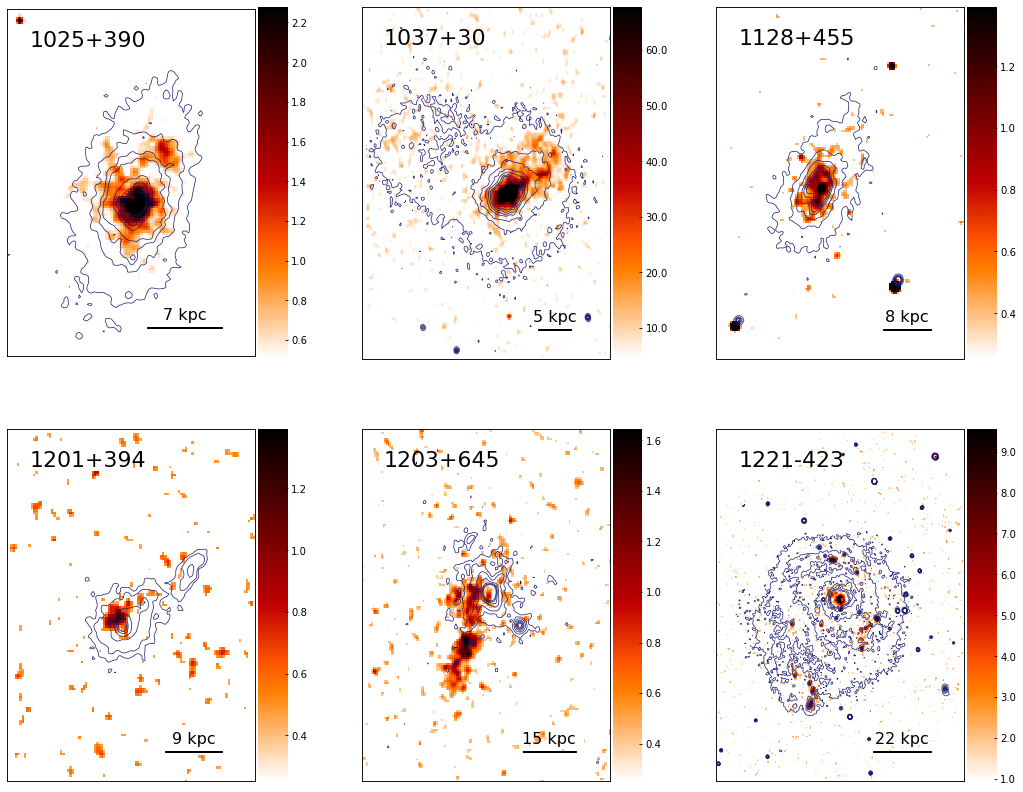

In [12]:
hdu_listUV = []
hdu_listOP = []
optimal_wcs = []
photflam = []

sources = [s3, s4, s5, s6, s7, s8]

for s in sources:
    
    image_hdu, header_hdu = read_image(hst_dir, s, 'uv')
    photflam.append(header_hdu['PHOTFLAM'])
    image_hdu_op = read_image(hst_dir, s, 'op')
    
    new_wcs, new_shape = find_optimal_wcs(hst_dir, s)
    reprojected_uv, reprojected_op_footprint = reproject_interp(image_hdu, new_wcs, new_shape)
    reprojected_uv = gaussian_filter(reprojected_uv, 1.0) #if s.n == '1201+394' else gaussian_filter(reprojected_uv, 1.5)
    reprojected_op, reprojected_op_footprint = reproject_interp(image_hdu_op, new_wcs, new_shape)
    reprojected_op = gaussian_filter(reprojected_op, 1.0) if s.n == '1221-423' else gaussian_filter(reprojected_op, 0.8)
    
    optimal_wcs.append(new_wcs)
    hdu_listUV.append(reprojected_uv)
    hdu_listOP.append(reprojected_op)


plot_uvop(s, optimal_wcs, photflam, hdu_listUV, hdu_listOP)

#plt.savefig('uv-op.pdf',facecolor='w', dpi=1000, bbox_inches='tight', pad_inches=0.5)
